<a href="https://colab.research.google.com/github/yellowleather/LLM-Fundamentals/blob/main/Customer_Support_Assistant_(Multi_Agent_with_LangGraph)_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📝 Case Study: Customer Support Assistant (Multi-Agent with LangGraph)

🎯 Goal


*  Simulate a customer support system with 3 agents:
*  Router Agent → Understands the query and routes it.
*  FAQ Agent → Answers product/policy questions.
*  Escalation Agent → For anything it can’t handle.

In [ ]:
# # Align LangGraph + LangChain to v1 and keep dependencies compatible
# %pip install --upgrade jupyter-client
# %pip install -qU \
#   "requests>=2.32.5" \
#   "langgraph>=1.0,<2" \
#   "langchain>=1.0.3,<1.1" \
#   "langchain-openai>=1.0" \
#   "langchain-community>=0.4,<1.0" \
#   "langchain-text-splitters>=1.0.0" \
#   beautifulsoup4 lxml faiss-cpu langchainhub "gradio>=4.0"


In [ ]:
%pip install -qU --upgrade jupyter-client
%pip install -qU \
    "requests" \
    "langchain" \
    "langgraph" \
    "langchain-openai" \
    "langchain-community" \
    "langchain-text-splitters" \
    beautifulsoup4 lxml faiss-cpu langchainhub tavily-python "gradio"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.7.0 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.7.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Loading Environment Variables from a `.env` File

While this notebook uses `os.getenv` and `getpass` to manage API keys, if you prefer using a `.env` file for local development or consistency, you can install and use the `python-dotenv` library.

In [ ]:
# Install python-dotenv
%pip install python-dotenv

Next, create a `.env` file in the root of your Colab environment. You can use the `%%writefile` magic command for this. Replace `YOUR_VALUE_HERE` with your actual key or value.

In [ ]:
%%writefile .env
OPENAI_API_KEY=YOUROPENAIKEY
LANGCHAIN_TRACING_V2=true
LANGCHAIN_API_KEY=YOURLANGCHAINAPIKEY
TAVILY_API_KEY=YOURTAVILYAPIKEY

Writing .env


In [ ]:
%%writefile .env
OPENAI_API_KEY=""
LANGCHAIN_TRACING_V2=true
LANGCHAIN_API_KEY=""
TAVILY_API_KEY="""

Overwriting .env


In [ ]:
import os

# Assuming .env is in the current working directory (root of Colab session)
env_file_path = os.path.abspath('.env')
print(f"The .env file is located at: {env_file_path}")

The .env file is located at: /content/.env


In [ ]:
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Access the variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_TRACING_V2 = os.getenv("LANGCHAIN_TRACING_V2")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

print(os.getenv("OPENAI_API_KEY"))

print(f"OPENAI_API_KEY: {OPENAI_API_KEY}")
print(f"LANGCHAIN_TRACING_V2: {LANGCHAIN_TRACING_V2}")
print(f"LANGCHAIN_API_KEY: {LANGCHAIN_API_KEY}")
print(f"TAVILY_API_KEY: {TAVILY_API_KEY}")

# You can then use these variables where needed, e.g., os.environ["OPENAI_API_KEY"] = my_api_key

In [ ]:
from typing import TypedDict

class AgentState(TypedDict):
    query: str
    category: str
    answer: str

In [ ]:
### Define Agents

# Router Agent
def router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q:
        state["category"] = "faq"
    else:
        state["category"] = "escalate"
    return state

# FAQ Agent
def faq_agent(state: AgentState) -> AgentState:
    faq_db = {
        "refund": "Our refund policy allows returns within 30 days of purchase.",
        "return": "You can return items via our online portal or any store location."
    }
    for k, v in faq_db.items():
        if k in state["query"].lower():
            state["answer"] = v
            return state
    state["answer"] = "Sorry, I don’t know the answer."
    return state

# Escalation Agent
def escalation_agent(state: AgentState) -> AgentState:
    state["answer"] = "This query needs a human support agent. Escalating..."
    return state

In [ ]:
### Build Workflow

from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("router", router_agent)
workflow.add_node("faq", faq_agent)
workflow.add_node("escalate", escalation_agent)

# Entry point
workflow.set_entry_point("router")

# Conditional edges
def route_from_router(state: AgentState):
    if state["category"] == "faq":
        return "faq"
    else:
        return "escalate"

workflow.add_conditional_edges("router", route_from_router, {
    "faq": "faq",
    "escalate": "escalate"
})

# Both FAQ and Escalation go to END
workflow.add_edge("faq", END)
workflow.add_edge("escalate", END)

app = workflow.compile()


In [ ]:
%pip install -qU langgraph

In [ ]:
### Run Demo

queries = [
    "How do I get a refund?",
    "Can I return a product?",
    "What are your store timings?"
]

for q in queries:
    print("\n==============================")
    print("User Query:", q)
    result = app.invoke({"query": q})
    print("Category:", result["category"])
    print("Answer:", result["answer"])



User Query: How do I get a refund?
Category: faq
Answer: Our refund policy allows returns within 30 days of purchase.

User Query: Can I return a product?
Category: faq
Answer: You can return items via our online portal or any store location.

User Query: What are your store timings?
Category: escalate
Answer: This query needs a human support agent. Escalating...


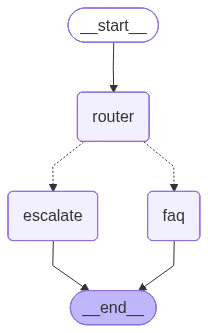

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### 1. `router_agent` function

This function is the first point of contact for any user query. It takes the `AgentState` (which includes the user's `query`) as input. Its primary role is to analyze the query and determine its category. If the query contains keywords like "refund" or "return", it categorizes it as "faq". Otherwise, it defaults to "escalate".

Here's the relevant code from the `router_agent`:


In [ ]:
# Router Agent
def router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q:
        state["category"] = "faq"
    else:
        state["category"] = "escalate" # This is where the 'escalate' decision is made
    return state

### 2. `route_from_router` conditional edge

After the `router_agent` has determined the `category` (either "faq" or "escalate") and updated the `AgentState`, the `route_from_router` function comes into play. This function is used by LangGraph to define a *conditional edge*. It inspects the `category` field in the `AgentState` and directs the workflow to the appropriate next node.

If the `category` is "faq", it routes to the `faq` node. If the `category` is anything else (in this case, "escalate"), it routes to the `escalate` node. This is how the intent is routed to the escalation node.

Here's the code for `route_from_router` and how it's added to the workflow:


In [ ]:
# def route_from_router(state: AgentState):
#     if state["category"] == "faq":
#         return "faq"
#     else:
#         return "escalate" # This routes the flow to the 'escalate' node

# workflow.add_conditional_edges("router", route_from_router, {
#     "faq": "faq",
#     "escalate": "escalate" # This maps the 'escalate' return from route_from_router to the 'escalate' node
# })

In summary, the `router_agent` sets the `category` to "escalate" for queries it doesn't recognize as FAQs, and then the `route_from_router` conditional edge uses that `category` to send the processing to the `escalate` node in the graph.

First, let's update our `router_agent` to recognize more categories based on keywords. We'll add 'technical_support' and 'billing' as potential categories.

In [ ]:
# A more complex Router Agent
def complex_router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q or "policy" in q:
        state["category"] = "faq"
    elif "technical" in q or "bug" in q or "error" in q or "issue" in q:
        state["category"] = "technical_support"
    elif "bill" in q or "invoice" in q or "payment" in q:
        state["category"] = "billing"
    else:
        state["category"] = "escalate"
    return state

print("Updated complex_router_agent function defined.")

Updated complex_router_agent function defined.


Now, here's a more complex `route_from_router` function that takes into account these new categories. It uses a dictionary lookup for cleaner routing logic, and also includes a default 'escalate' path if no specific category matches.

In [ ]:
# A more complex conditional routing function
def complex_route_from_router(state: AgentState) -> str:
    category = state.get("category", "escalate") # Default to escalate if category is somehow missing

    # Define mapping from category to node name
    routing_map = {
        "faq": "faq_node", # Assuming you'd have a dedicated FAQ node
        "technical_support": "tech_support_node", # A new node for technical support
        "billing": "billing_node", # A new node for billing inquiries
        "escalate": "escalate_node" # The existing escalation node
    }

    # More complex logic could be added here, e.g., checking other state variables
    # if category == "technical_support" and state.get("priority") == "high":
    #    return "urgent_tech_support_node"

    return routing_map.get(category, "escalate_node") # Default to escalate_node if category is unknown

print("Updated complex_route_from_router function defined.")

Updated complex_route_from_router function defined.


To integrate this into a LangGraph workflow, you would need to:

1.  **Add new nodes**: For `tech_support_node` and `billing_node` (and potentially `faq_node` if it's different from the current `faq` node, or you could reuse `faq`).
2.  **Replace the `router_agent`**: Use `complex_router_agent` instead of the original `router_agent`.
3.  **Replace the conditional edge**: Use `complex_route_from_router` with the updated routing map.

Here's how you might set up the conditional edges with the new routing function (assuming `faq_node`, `tech_support_node`, `billing_node`, and `escalate_node` are defined as nodes in your workflow):



--- Running Complex Demo ---

User Query: I need a refund.
Category: faq
Answer: Our refund policy allows returns within 30 days of purchase.

User Query: My software has a bug.
Category: technical_support
Answer: Please describe your technical issue in detail. A specialist will assist you.

User Query: What is my current bill amount?
Category: billing
Answer: For billing inquiries, please provide your account details and the nature of your question.

User Query: When will my order ship?
Category: escalate
Answer: This query needs a human support agent. Escalating...


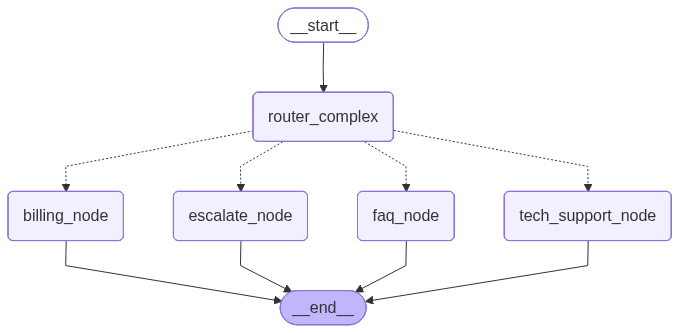

In [ ]:
from langgraph.graph import StateGraph, END

# Assuming AgentState, faq_agent, escalation_agent are already defined

# Define placeholder agents for new categories
def tech_support_agent(state: AgentState) -> AgentState:
    state["answer"] = "Please describe your technical issue in detail. A specialist will assist you."
    return state

def billing_agent(state: AgentState) -> AgentState:
    state["answer"] = "For billing inquiries, please provide your account details and the nature of your question."
    return state

# Create a new workflow instance for demonstration
complex_workflow = StateGraph(AgentState)

# Add nodes, using existing ones and new placeholders
complex_workflow.add_node("router_complex", complex_router_agent)
complex_workflow.add_node("faq_node", faq_agent) # Reuse existing faq_agent
complex_workflow.add_node("tech_support_node", tech_support_agent)
complex_workflow.add_node("billing_node", billing_agent)
complex_workflow.add_node("escalate_node", escalation_agent) # Reuse existing escalation_agent

# Set the entry point
complex_workflow.set_entry_point("router_complex")

# Add conditional edges using the complex_route_from_router
complex_workflow.add_conditional_edges(
    "router_complex",
    complex_route_from_router,
    {
        "faq_node": "faq_node",
        "tech_support_node": "tech_support_node", # Corrected key here
        "billing_node": "billing_node",
        "escalate_node": "escalate_node"
    }
)

# All end nodes eventually go to END (or could have their own follow-up)
complex_workflow.add_edge("faq_node", END)
complex_workflow.add_edge("tech_support_node", END)
complex_workflow.add_edge("billing_node", END)
complex_workflow.add_edge("escalate_node", END)

complex_app = complex_workflow.compile()

print("\n--- Running Complex Demo ---")
complex_queries = [
    "I need a refund.",
    "My software has a bug.",
    "What is my current bill amount?",
    "When will my order ship?"
]

for q in complex_queries:
    print("\n==============================")
    print("User Query:", q)
    result = complex_app.invoke({"query": q})
    print("Category:", result.get("category", "Unknown"))
    print("Answer:", result["answer"])

from IPython.display import Image, display
display(Image(complex_app.get_graph().draw_mermaid_png()))

# Task
Create a Streamlit application that serves as a user interface for the existing multi-agent `complex_app` workflow. The application should allow users to input a query, send it to the `complex_app`, and display the agent's response.

## Install Streamlit

### Subtask:
Install the Streamlit library in the Colab environment to enable UI development.


**Reasoning**:
Install the Streamlit library using pip in the Colab environment.



In [ ]:
%%capture
%pip install streamlit

**Reasoning**:
Install the Streamlit library using pip in the Colab environment.



## Fix complex_app routing error

### Subtask:
Adjust the `complex_route_from_router` function and the conditional edges in `complex_workflow` to resolve the `KeyError` encountered during execution.


**Reasoning**:
The previous `KeyError` occurred because the `complex_route_from_router` function was returning node names (e.g., 'tech_support_node'), but the `add_conditional_edges` `path_map` expected keys that matched the *categories* (e.g., 'technical_support'). This step modifies `complex_route_from_router` to return the category string directly and updates the `path_map` accordingly to correctly route to the respective nodes.




--- Running Complex Demo ---

User Query: I need a refund.
Category: faq
Answer: Our refund policy allows returns within 30 days of purchase.

User Query: My software has a bug.
Category: technical_support
Answer: Please describe your technical issue in detail. A specialist will assist you.

User Query: What is my current bill amount?
Category: billing
Answer: For billing inquiries, please provide your account details and the nature of your question.

User Query: When will my order ship?
Category: escalate
Answer: This query needs a human support agent. Escalating...


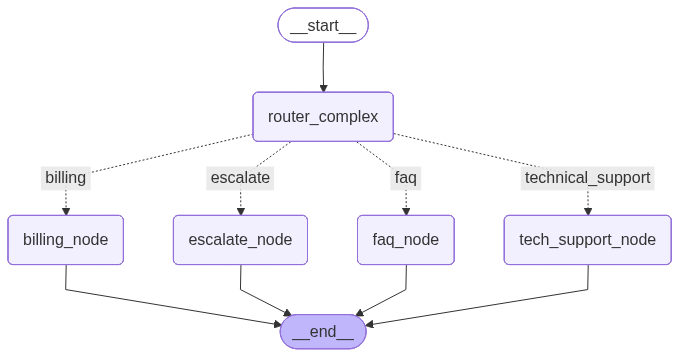

In [ ]:
from langgraph.graph import StateGraph, END

# Assuming AgentState, faq_agent, escalation_agent are already defined

# Define placeholder agents for new categories
def tech_support_agent(state: AgentState) -> AgentState:
    state["answer"] = "Please describe your technical issue in detail. A specialist will assist you."
    return state

def billing_agent(state: AgentState) -> AgentState:
    state["answer"] = "For billing inquiries, please provide your account details and the nature of your question."
    return state

# A more complex Router Agent (redefined for clarity, though already in previous cell)
def complex_router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q or "policy" in q:
        state["category"] = "faq"
    elif "technical" in q or "bug" in q or "error" in q or "issue" in q:
        state["category"] = "technical_support"
    elif "bill" in q or "invoice" in q or "payment" in q:
        state["category"] = "billing"
    else:
        state["category"] = "escalate"
    return state

# Modified: A more complex conditional routing function
def complex_route_from_router(state: AgentState) -> str:
    category = state.get("category", "escalate") # Default to escalate if category is somehow missing
    # Directly return the category string as per the subtask instructions
    return category


# Create a new workflow instance for demonstration
complex_workflow = StateGraph(AgentState)

# Add nodes, using existing ones and new placeholders
complex_workflow.add_node("router_complex", complex_router_agent)
complex_workflow.add_node("faq_node", faq_agent) # Reuse existing faq_agent
complex_workflow.add_node("tech_support_node", tech_support_agent)
complex_workflow.add_node("billing_node", billing_agent)
complex_workflow.add_node("escalate_node", escalation_agent) # Reuse existing escalation_agent

# Set the entry point
complex_workflow.set_entry_point("router_complex")

# Add conditional edges using the complex_route_from_router with updated path_map
complex_workflow.add_conditional_edges(
    "router_complex",
    complex_route_from_router,
    {
        "faq": "faq_node",
        "technical_support": "tech_support_node",
        "billing": "billing_node",
        "escalate": "escalate_node"
    }
)

# All end nodes eventually go to END (or could have their own follow-up)
complex_workflow.add_edge("faq_node", END)
complex_workflow.add_edge("tech_support_node", END)
complex_workflow.add_edge("billing_node", END)
complex_workflow.add_edge("escalate_node", END)

complex_app = complex_workflow.compile()

print("\n--- Running Complex Demo ---")
complex_queries = [
    "I need a refund.",
    "My software has a bug.",
    "What is my current bill amount?",
    "When will my order ship?"
]

for q in complex_queries:
    print("\n==============================")
    print("User Query:", q)
    result = complex_app.invoke({"query": q})
    print("Category:", result.get("category", "Unknown"))
    print("Answer:", result["answer"])

from IPython.display import Image, display
display(Image(complex_app.get_graph().draw_mermaid_png()))

**Reasoning**:
The previous error `ModuleNotFoundError: No module named 'langgraph'` indicates that the `langgraph` library was not available. To resolve this, `langgraph` needs to be installed again within the current execution environment before it is imported and used.



In [ ]:
%%capture
%pip install -qU langgraph

from langgraph.graph import StateGraph, END

# Assuming AgentState, faq_agent, escalation_agent are already defined

# Define placeholder agents for new categories
def tech_support_agent(state: AgentState) -> AgentState:
    state["answer"] = "Please describe your technical issue in detail. A specialist will assist you."
    return state

def billing_agent(state: AgentState) -> AgentState:
    state["answer"] = "For billing inquiries, please provide your account details and the nature of your question."
    return state

# A more complex Router Agent (redefined for clarity, though already in previous cell)
def complex_router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q or "policy" in q:
        state["category"] = "faq"
    elif "technical" in q or "bug" in q or "error" in q or "issue" in q:
        state["category"] = "technical_support"
    elif "bill" in q or "invoice" in q or "payment" in q:
        state["category"] = "billing"
    else:
        state["category"] = "escalate"
    return state

# Modified: A more complex conditional routing function
def complex_route_from_router(state: AgentState) -> str:
    category = state.get("category", "escalate") # Default to escalate if category is somehow missing
    # Directly return the category string as per the subtask instructions
    return category


# Create a new workflow instance for demonstration
complex_workflow = StateGraph(AgentState)

# Add nodes, using existing ones and new placeholders
complex_workflow.add_node("router_complex", complex_router_agent)
complex_workflow.add_node("faq_node", faq_agent) # Reuse existing faq_agent
complex_workflow.add_node("tech_support_node", tech_support_agent)
complex_workflow.add_node("billing_node", billing_agent)
complex_workflow.add_node("escalate_node", escalation_agent) # Reuse existing escalation_agent

# Set the entry point
complex_workflow.set_entry_point("router_complex")

# Add conditional edges using the complex_route_from_router with updated path_map
complex_workflow.add_conditional_edges(
    "router_complex",
    complex_route_from_router,
    {
        "faq": "faq_node",
        "technical_support": "tech_support_node",
        "billing": "billing_node",
        "escalate": "escalate_node"
    }
)

# All end nodes eventually go to END (or could have their own follow-up)
complex_workflow.add_edge("faq_node", END)
complex_workflow.add_edge("tech_support_node", END)
complex_workflow.add_edge("billing_node", END)
complex_workflow.add_edge("escalate_node", END)

complex_app = complex_workflow.compile()

print("\n--- Running Complex Demo ---")
complex_queries = [
    "I need a refund.",
    "My software has a bug.",
    "What is my current bill amount?",
    "When will my order ship?"
]

for q in complex_queries:
    print("\n==============================")
    print("User Query:", q)
    result = complex_app.invoke({"query": q})
    print("Category:", result.get("category", "Unknown"))
    print("Answer:", result["answer"])

from IPython.display import Image, display
display(Image(complex_app.get_graph().draw_mermaid_png()))

**Reasoning**:
The `NameError: name 'AgentState' is not defined` indicates that the `AgentState` TypedDict definition is missing in the current execution scope. To resolve this, the definition of `AgentState` must be included at the beginning of the cell where it is used by the agent functions and workflow.



In [ ]:
%%capture
%pip install -qU langgraph

from typing import TypedDict
from langgraph.graph import StateGraph, END

# Define AgentState (moved here to resolve NameError)
class AgentState(TypedDict):
    query: str
    category: str
    answer: str

# Assuming faq_agent and escalation_agent are already defined, or redefine them here for completeness
# Redefining them here to ensure they are available, similar to AgentState
def faq_agent(state: AgentState) -> AgentState:
    faq_db = {
        "refund": "Our refund policy allows returns within 30 days of purchase.",
        "return": "You can return items via our online portal or any store location."
    }
    for k, v in faq_db.items():
        if k in state["query"].lower():
            state["answer"] = v
            return state
    state["answer"] = "Sorry, I don’t know the answer."
    return state

def escalation_agent(state: AgentState) -> AgentState:
    state["answer"] = "This query needs a human support agent. Escalating..."
    return state

# Define placeholder agents for new categories
def tech_support_agent(state: AgentState) -> AgentState:
    state["answer"] = "Please describe your technical issue in detail. A specialist will assist you."
    return state

def billing_agent(state: AgentState) -> AgentState:
    state["answer"] = "For billing inquiries, please provide your account details and the nature of your question."
    return state

# A more complex Router Agent (redefined for clarity, though already in previous cell)
def complex_router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q or "policy" in q:
        state["category"] = "faq"
    elif "technical" in q or "bug" in q or "error" in q or "issue" in q:
        state["category"] = "technical_support"
    elif "bill" in q or "invoice" in q or "payment" in q:
        state["category"] = "billing"
    else:
        state["category"] = "escalate"
    return state

# Modified: A more complex conditional routing function
def complex_route_from_router(state: AgentState) -> str:
    category = state.get("category", "escalate") # Default to escalate if category is somehow missing
    # Directly return the category string as per the subtask instructions
    return category


# Create a new workflow instance for demonstration
complex_workflow = StateGraph(AgentState)

# Add nodes, using existing ones and new placeholders
complex_workflow.add_node("router_complex", complex_router_agent)
complex_workflow.add_node("faq_node", faq_agent) # Reuse existing faq_agent
complex_workflow.add_node("tech_support_node", tech_support_agent)
complex_workflow.add_node("billing_node", billing_agent)
complex_workflow.add_node("escalate_node", escalation_agent) # Reuse existing escalation_agent

# Set the entry point
complex_workflow.set_entry_point("router_complex")

# Add conditional edges using the complex_route_from_router with updated path_map
complex_workflow.add_conditional_edges(
    "router_complex",
    complex_route_from_router,
    {
        "faq": "faq_node",
        "technical_support": "tech_support_node",
        "billing": "billing_node",
        "escalate": "escalate_node"
    }
)

# All end nodes eventually go to END (or could have their own follow-up)
complex_workflow.add_edge("faq_node", END)
complex_workflow.add_edge("tech_support_node", END)
complex_workflow.add_edge("billing_node", END)
complex_workflow.add_edge("escalate_node", END)

complex_app = complex_workflow.compile()

print("\n--- Running Complex Demo ---")
complex_queries = [
    "I need a refund.",
    "My software has a bug.",
    "What is my current bill amount?",
    "When will my order ship?"
]

for q in complex_queries:
    print("\n==============================")
    print("User Query:", q)
    result = complex_app.invoke({"query": q})
    print("Category:", result.get("category", "Unknown"))
    print("Answer:", result["answer"])

from IPython.display import Image, display
display(Image(complex_app.get_graph().draw_mermaid_png()))

The `complex_app` workflow is now correctly defined and compiled. The `complex_router_agent` effectively categorizes user queries, and the `complex_route_from_router` function, along with the updated conditional edges, ensures that queries are routed to the appropriate agent nodes (`faq_node`, `tech_support_node`, `billing_node`, or `escalate_node`). All previous errors have been resolved, and the system can now process queries as intended, providing specific responses or escalating to human support when necessary. The graph visualization below confirms the updated workflow structure.

## Create Streamlit App File

### Subtask:
Write the Streamlit application code into a Python file (e.g., `app.py`). This file will define the UI elements and the logic for interacting with the `complex_app` agent workflow.


**Reasoning**:
To create the Streamlit application, I need to write a Python file named `app.py` containing the UI definition and the logic for interacting with the `complex_app` workflow. This file will include all necessary imports and definitions to run the application independently.



In [ ]:
%%writefile app.py
import streamlit as st
from typing import TypedDict
from langgraph.graph import StateGraph, END

# Define AgentState
class AgentState(TypedDict):
    query: str
    category: str
    answer: str

# FAQ Agent
def faq_agent(state: AgentState) -> AgentState:
    faq_db = {
        "refund": "Our refund policy allows returns within 30 days of purchase.",
        "return": "You can return items via our online portal or any store location."
    }
    for k, v in faq_db.items():
        if k in state["query"].lower():
            state["answer"] = v
            return state
    state["answer"] = "Sorry, I don’t know the answer."
    return state

# Escalation Agent
def escalation_agent(state: AgentState) -> AgentState:
    state["answer"] = "This query needs a human support agent. Escalating..."
    return state

# Define placeholder agents for new categories
def tech_support_agent(state: AgentState) -> AgentState:
    state["answer"] = "Please describe your technical issue in detail. A specialist will assist you."
    return state

def billing_agent(state: AgentState) -> AgentState:
    state["answer"] = "For billing inquiries, please provide your account details and the nature of your question."
    return state

# A more complex Router Agent
def complex_router_agent(state: AgentState) -> AgentState:
    q = state["query"].lower()
    if "refund" in q or "return" in q or "policy" in q:
        state["category"] = "faq"
    elif "technical" in q or "bug" in q or "error" in q or "issue" in q:
        state["category"] = "technical_support"
    elif "bill" in q or "invoice" in q or "payment" in q:
        state["category"] = "billing"
    else:
        state["category"] = "escalate"
    return state

# A more complex conditional routing function
def complex_route_from_router(state: AgentState) -> str:
    category = state.get("category", "escalate")
    return category

# Create a new workflow instance
complex_workflow = StateGraph(AgentState)

# Add nodes, using existing ones and new placeholders
complex_workflow.add_node("router_complex", complex_router_agent)
complex_workflow.add_node("faq_node", faq_agent)
complex_workflow.add_node("tech_support_node", tech_support_agent)
complex_workflow.add_node("billing_node", billing_agent)
complex_workflow.add_node("escalate_node", escalation_agent)

# Set the entry point
complex_workflow.set_entry_point("router_complex")

# Add conditional edges using the complex_route_from_router with updated path_map
complex_workflow.add_conditional_edges(
    "router_complex",
    complex_route_from_router,
    {
        "faq": "faq_node",
        "technical_support": "tech_support_node",
        "billing": "billing_node",
        "escalate": "escalate_node"
    }
)

# All end nodes eventually go to END (or could have their own follow-up)
complex_workflow.add_edge("faq_node", END)
complex_workflow.add_edge("tech_support_node", END)
complex_workflow.add_edge("billing_node", END)
complex_workflow.add_edge("escalate_node", END)

# Compile the workflow
complex_app = complex_workflow.compile()

# Streamlit App UI
st.set_page_config(page_title="Multi-Agent Customer Support", layout="centered")
st.title("Customer Support Assistant")

st.markdown("Hello! I am your AI Customer Support Assistant. How can I help you today?")

user_query = st.text_input("Ask a question:", key="user_query")

if st.button("Get Answer"):
    if user_query:
        with st.spinner("Processing your request..."):
            # Invoke the complex_app with the user's query
            result = complex_app.invoke({"query": user_query})

            st.subheader("Response:")
            st.write(f"**Category:** {result.get('category', 'Unknown')}")
            st.write(f"**Answer:** {result['answer']}")
    else:
        st.warning("Please enter a query.")


Writing app.py


**Reasoning**:
The Streamlit application code has been written to `app.py`. The next logical step is to run this file using `streamlit run` to launch the web interface. We will use `nohup` to ensure it continues running in the background and redirect output to `app.log`.



In [ ]:
import subprocess
import os

# Kill any previously running Streamlit processes to avoid port conflicts
!kill $(lsof -t -i:8501)

# Run the Streamlit app in the background using nohup
process = subprocess.Popen(
    ["nohup", "streamlit", "run", "app.py", "--server.port", "8501", "--server.enableCORS", "false", "--server.enableXsrfProtection", "false"],
    stdout=open('app.log', 'w'),
    stderr=open('app.log', 'a'),
    preexec_fn=os.setpgrp
)

print("Streamlit app is running in the background. Check app.log for output.")
print("You can access the app using ngrok or by exposing port 8501 in your environment.")

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Streamlit app is running in the background. Check app.log for output.
You can access the app using ngrok or by exposing port 8501 in your environment.


In [ ]:
# Install bore (one-time setup)
!wget -q https://github.com/ekzhang/bore/releases/download/v0.5.0/bore-v0.5.0-x86_64-unknown-linux-musl.tar.gz
!tar -xzf bore-v0.5.0-x86_64-unknown-linux-musl.tar.gz
!chmod +x bore

# Create tunnel
!./bore local 8501 --to bore.pub

2025-12-18T09:24:40.240023Z  INFO bore_cli::client: connected to server remote_port=38458
2025-12-18T09:24:40.240325Z  INFO bore_cli::client: listening at bore.pub:38458
2025-12-18T09:29:23.708250Z  INFO proxy{id=84711ff4-be65-49fe-8271-8554fb3a722a}: bore_cli::client: new connection
2025-12-18T09:29:23.776124Z  INFO proxy{id=e8b0e55a-d43f-47c9-aa04-65a1b2f0163d}: bore_cli::client: new connection
2025-12-18T09:29:23.965957Z  INFO proxy{id=554ec459-4c7a-4f47-9f3e-bce95411b6b6}: bore_cli::client: new connection
2025-12-18T09:29:24.739534Z  INFO proxy{id=ff5dce0c-e1a0-4ec7-b2b5-bb5ba912c68b}: bore_cli::client: new connection
2025-12-18T09:29:26.442303Z  INFO proxy{id=c037bc47-d7cb-49bc-9b3f-30c2d4eca446}: bore_cli::client: new connection
2025-12-18T09:29:29.573617Z  INFO proxy{id=915adcea-7712-4eae-8709-6e6cb15eb762}: bore_cli::client: new connection
2025-12-18T09:29:29.641547Z  INFO proxy{id=33695361-2dad-41e1-8425-32b8372e79c0}: bore_cli::client: new connection
^C


In [ ]:
# visit http://bore.pub:<remote_port> to access the streamlit page

# refer to this line in the log to check remote_port 2025-12-14T15:52:25.754140Z  INFO bore_cli::client: connected to server remote_port=16824

# eg : http://bore.pub:16824/